# AI534 Implementation Assignment 3###

**Deadline**: Sunday, Nov. 19, by 11:59pm

**Submission**: Submit 1) your completed notebook in ipynb format, and 2) a PDF export of the completed notebook with outputs.

**Late Submission**: Please see the syllabus for the late submission policy.

In this assignment, you will use the sklearn package to experiment with Support Vector Machines and Naive Bayes models. The experiments will utilize the validation data to perform parameter tuning and explore the impact of different parameters on the models' behavior.

You may modify the starter code as you see fit, including changing existing or adding new code blocks. However, please ensure that your modifications are clear so that your TA can easily understand what you are doing and why.

First let's import the packages needed for this assignment.

In [113]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import metrics
import seaborn as sns
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from prettytable import PrettyTable

# Data
The data for this assignment consists of a natural language sentiment dataset sourced from Twitter. The first column indicates sentiment of the tweets (zero representing negative sentiment and one for positive sentiment) and the second column contains the text of the tweets.

Two datasets are provided on Canvas: a training set named 'IA3-training.csv' and a validation set named 'IA3-dev.csv'. You will use the training set to build your models and the validation set to tune the parameters and observe their impacts.

Let's load the data.

In [114]:
from google.colab import drive
drive.mount('/content/gdrive')

train_path = '/content/gdrive/My Drive/AI534/IA3-train.csv' # DO NOT MODIFY THIS. Please make sure your data has this exact path
val_path = '/content/gdrive/My Drive/AI534/IA3-dev.csv' # DO NOT MODIFY THIS. Please make sure your data has this exact path
train_data = pd.read_csv(train_path)
val_data = pd.read_csv(val_path)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# Part 0: Preprocessing to form BoW Representation (5 pts)
In this part, you will take the text of the tweets and convert it to the bag-of-words (BoW) representation that can be processed by the model you will train. First, you will build your BoW vocabulary using the training set and represent your training set using *tf-idf*.

Here ***tf*** stands for term frequecy and is defined as follows for a document $d$ and term $t$:

$TF(t,d) = \frac{\mbox{Num. of times } t \mbox{ appears in } d}{\mbox{Total number of terms in }d}$

and ***idf*** stands for inverse document frequency and is defined as follows for a term $t$ and a document collection $D$

$IDF(t, D) = \log(\frac{N}{|\{d\in D: t\in d\}|}) $


where $N$ is the total number of documents in $D$, and $|\{d\in D: t\in d\}|$ is the number of documents that contain term $t$.


Specifically, you will be using the **TfidfVectorizer** class from the sklearn.feature_extraction.text package (https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html#). For this assignment, you should set '***stop_words=english***', other parameters can remain at their default values.

The specific methods you will need to use include:

*   ***fit_transform()***:  You will apply this function to the training text to learn the vocabulary and the inverse document frequency, and generate the tf-idf representation for the training documents.

*   ***transform()***: you will apply this function to the validation text to generate the tf-idf representation for the validation documents, using a vocabulary and inverse document frequency that are already learned from the training data.

Note that both of the above methods return a sparse matrix representation of the documents. This format can be directly used by the SVM package and the Naive Bayes Package for learning. Using a sparse matrix for your document representation is computationally much more efficient, especially for SVM models.

Now let's take a look at the tf-idf representation of your training dataset and see if we can find some useful words. First, identify the top 20 words with the highest cumulative TF-IDF scores in two separate categories: words from documents labeled as 'positive', and words from those labeled as 'negative'. Then, report any words that appear in both lists, and the list of words, distinctly associated with the 'positive' and 'negative' categories, respectively.


In [115]:

# Below is the function to remove '@' from the beginning
def remove_at(text):
    if text.startswith('@'):
        return text[1:]
    return text


train_text = train_data['text'].tolist()
val_text = val_data['text'].tolist()

# Initializing TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(stop_words='english', preprocessor=remove_at)

# Learning vocabulary and inverse document frequency from training data
tfidf_train = tfidf_vectorizer.fit_transform(train_text)

# Transforming validation text
tfidf_val = tfidf_vectorizer.transform(val_text)

tfidf_train_tokens = tfidf_vectorizer.get_feature_names_out(tfidf_train)
tfidf_val_tokens = tfidf_vectorizer.get_feature_names_out(tfidf_val)

df_train_tfidfvect = pd.DataFrame(data = tfidf_train.toarray(),columns = tfidf_train_tokens)
df_val_tfidfvect = pd.DataFrame(data = tfidf_val.toarray(),columns = tfidf_train_tokens)

df_train_tfidfvect['sentiment_new_added'] = train_data[['sentiment']]
positive_sentiment_df = df_train_tfidfvect[df_train_tfidfvect['sentiment_new_added'] == 1]
negative_sentiment_df = df_train_tfidfvect[df_train_tfidfvect['sentiment_new_added'] == 0]

# Create a new row with these sums at the end of positive_sentiment_df
column_sums_p = positive_sentiment_df.sum()
positive_sentiment_df.loc['Total'] = column_sums_p
totals_df_p = pd.DataFrame(column_sums_p, columns=['Total'])
totals_df_p = totals_df_p.T
sorted_totals_p = totals_df_p.sort_values(by='Total', axis=1, ascending=False)

positive_tweets=sorted_totals_p.drop(columns='sentiment_new_added').iloc[:, :20]


# Create a new row with these sums at the end of positive_sentiment_df
column_sums_n = negative_sentiment_df.sum()
negative_sentiment_df.loc['Total'] = column_sums_n
totals_df_n = pd.DataFrame(column_sums_n, columns=['Total'])
totals_df_n = totals_df_n.T
sorted_totals_n = totals_df_n.sort_values(by='Total', axis=1, ascending=False)

negative_tweets=sorted_totals_n.drop(columns='sentiment_new_added').iloc[:, :20]



<ipython-input-115-d125ddd1890f>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_sentiment_df.loc['Total'] = column_sums_p
<ipython-input-115-d125ddd1890f>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_sentiment_df.loc['Total'] = column_sums_n


In [116]:
positive_table = PrettyTable()
positive_table.field_names = ["Word", "Count"]

for word in positive_tweets.columns:
    count = positive_tweets[word]['Total']
    positive_table.add_row([word, count])

print("Positive Sentiment - Top 20 Words:")
print(positive_table)

# Print the first 20 words with negative sentiment in a nice table
negative_table = PrettyTable()
negative_table.field_names = ["Word", "Count"]

for word in negative_tweets.columns:
    count = negative_tweets[word]['Total']
    negative_table.add_row([word, count])

print("Negative Sentiment - Top 20 Words:")
print(negative_table)

Positive Sentiment - Top 20 Words:
+---------------+--------------------+
|      Word     |       Count        |
+---------------+--------------------+
|    JetBlue    | 89.61677174444957  |
|     thanks    | 83.67778602970985  |
|  SouthwestAir | 82.84132274449077  |
|     thank     | 74.85745394755267  |
|     Thanks    | 66.18393041356202  |
|     Thank     | 65.90686582119062  |
|     united    | 62.466059480233696 |
|  AmericanAir  | 51.318303730467605 |
|   USAirways   |  36.3818850550177  |
|     great     | 36.319533518437396 |
|      http     | 32.93939692285962  |
| VirginAmerica | 32.162492583565864 |
|     flight    | 32.024805681233275 |
|    service    | 23.111520888930407 |
|      love     | 22.490114537427615 |
|      just     | 22.45536717111365  |
|      guys     | 22.326426727952917 |
|    awesome    | 21.470913434840195 |
|      best     | 20.374107490667587 |
|      good     | 19.867882164527796 |
+---------------+--------------------+
Negative Sentiment - Top 20 W

In [117]:
print("Reporting Common, distinctly positive and distinctly negative words")

distinct_positive_words = []
distinct_negative_words = []

# Iterate over words in positive tweets
for word in positive_tweets.columns:
    count = positive_tweets[word]['Total']
    positive_table.add_row([word, count])

    # Check if the word is also present in negative tweets
    if word in negative_tweets.columns:
        # Add the word to the distinct positive words list
        distinct_positive_words.append(word)

# Iterate over words in negative tweets
for word in negative_tweets.columns:
    count = negative_tweets[word]['Total']
    negative_table.add_row([word, count])

    # Check if the word is not present in positive tweets
    if word not in positive_tweets.columns:
        # Add the word to the distinct negative words list
        distinct_negative_words.append(word)


# Print words that appear in both lists
print("\nWords Common in Both Positive and Negative Sentiment:")
print(distinct_positive_words)

# Print words distinctly associated with positive sentiment
print("\nDistinctly Positive Words:")
print(set(positive_tweets.columns) - set(distinct_positive_words))

# Print words distinctly associated with negative sentiment
print("\nDistinctly Negative Words:")
print(set(distinct_negative_words) - set(positive_tweets.columns))

Reporting Common, distinctly positive and distinctly negative words

Words Common in Both Positive and Negative Sentiment:
['JetBlue', 'SouthwestAir', 'united', 'AmericanAir', 'USAirways', 'flight', 'service', 'just']

Distinctly Positive Words:
{'VirginAmerica', 'Thank', 'great', 'thank', 'guys', 'good', 'Thanks', 'http', 'thanks', 'love', 'best', 'awesome'}

Distinctly Negative Words:
{'plane', 'hour', 'hold', 'Flight', 'customer', 'help', 'Flightled', 'hours', 'amp', 'time', 'delayed', 'Cancelled'}


**Question**
1. Examine the types of words present in each of the three categories: 'common', 'positive', and 'negative'. Describe the nature and characteristics of these words.
2. Reflect on how a linear classification model might utilize the words from each category. What are your expectations regarding the sign (positive or negative) and magnitude (size) of the weights that would be assigned to these words by the model?

**1. Analysis of Word Categories**

Examination of words that appear in both positive and negative airline-related tweets reveals common terms like "JetBlue," "SouthwestAir," "united," "AmericanAir," and "USAirways," as well as general terms like "flight" and "service." While these words are not inherently emotional, they provide crucial context for airline-related tweets. Positive tweets often contain phrases like "Thank," "thanks," and "Thank you," along with positive adjectives like "great," "good," and "awesome." Mentions of "VirginAmerica" also tend to indicate positive sentiment. On the other hand, negative tweets often contain terms like "delayed," "Cancelled," "hour," "help," "Flightled," and "customer," reflecting dissatisfaction and negative experiences.

**2. Reflection on Linear Classification Model**
In a linear classification model, these words likely play a significant role in predicting sentiment. Common words might receive moderate weights due to their role in providing general context. Distinctly positive words, such as those expressing gratitude or high satisfaction, are expected to receive positive weights with a high impact, reflecting their importance in predicting positive sentiment. Conversely, distinctly negative words, such as those indicating delays, cancellations, or dissatisfaction, are expected to receive negative weights with a significant impact, emphasizing their role in predicting negative sentiment. Overall, the model is expected to learn associations between specific words and sentiments, enabling it to make predictions based on the presence or absence of key terms in airline-related tweets.




# Part 1. (30 pts) Linear SVM.
Use sklearn to train linear SVMs and tune the hyperparameter $c$ using grid search, considering $c = 10^i$ with $i$ ranging from -3 to 3, based on the validation accuracy. For each $c$ value, please
1. build a linear SVM model using the svm.SVC class
2. record the total number of support vectors of your model
3. evaluate the model's accuracy on the training data and validation data respectively.


Please produce the following two plots:
1.   Accuracy vs. $c$. In this plot, please plot both the training and validation accuracy as a function of the $c$ parameter (using log scale for $c$)
2.   Number of support vectors vs. $c$. In this plot, please plot the # of total support vectors for your SVM mdoel as a function of the $c$ parameter (using log scale for $c$).

In [118]:
X_train = tfidf_train
Xtrain_arr = np.array(X_train.toarray())

X_test = tfidf_val
Xtest_arr = np.array(X_test.toarray())

Ytrain = np.array(train_data['sentiment'])
Ytest_arr = np.array(val_data['sentiment'])
sv_array_linear = []
sv = []
training_acc_linear = []
validation_acc_linear = []

c = 10.0 ** np.arange(-3, 4)
best_params = {'C': None}
best_accuracy = 0.0

for cval in c:
    svc_linear_model = svm.SVC(kernel = 'linear', C = cval)
    svc_linear_model.fit(X_train, Ytrain)
    w = svc_linear_model.dual_coef_[0]
    # print("\n .................... \n")

    #making predictions on training data
    trainingPredictions = svc_linear_model.predict(Xtrain_arr)

    # print("For C value:", cval)
    #checking the support vector count
    sv = sum(svc_linear_model.n_support_)
    # print("Support Vector count:", sv)
    sv_array_linear.append(sv)

    #checking training accuracy
    temp_train = metrics.accuracy_score(Ytrain, trainingPredictions)
    # print("Training Accuracy:", temp_train)
    training_acc_linear.append(temp_train)


    #checking validation accuracy
    y = svc_linear_model.predict(X_test)
    temp_val = metrics.accuracy_score(y, Ytest_arr)
    # print("Validation Accuracy:", temp_val)
    validation_acc_linear.append(temp_val)

    #grid search based on validation accuracy
    if temp_val> best_accuracy:
      best_accuracy = temp_val
      best_params['C'] = cval


for i in range(0, len(c)):
    print(c[i], "  ", sv_array_linear[i], "  ", training_acc_linear[i], " ", validation_acc_linear[i])

print("Best validation accuracy =", best_accuracy)
print("Best Parameter =", best_params)



0.001    3696    0.7963333333333333   0.7904
0.01    4036    0.7963333333333333   0.7904
0.1    3878    0.8546666666666667   0.8512
1.0    3391    0.9723333333333334   0.9232
10.0    2970    0.9978888888888889   0.9096
100.0    2762    0.9991111111111111   0.8968
1000.0    2513    0.9991111111111111   0.8936
Best validation accuracy = 0.9232
Best Parameter = {'C': 1.0}


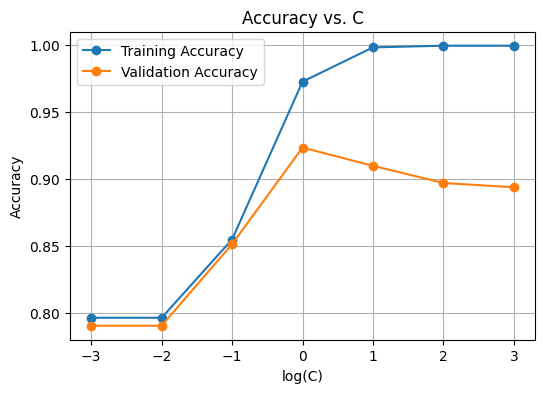

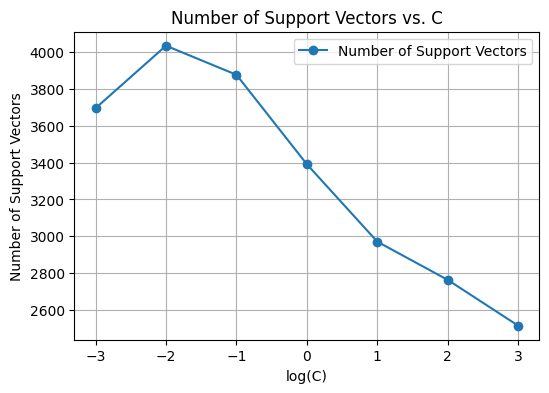

In [119]:
# Plotting
plt.figure(figsize=(6, 4))
plt.plot(np.log10(c), training_acc_linear, marker='o', label='Training Accuracy')
plt.plot(np.log10(c), validation_acc_linear, marker='o', label='Validation Accuracy')

# Set plot labels and title
plt.xlabel('log(C)')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. C')
plt.legend()
plt.grid(True)
plt.show()


# Plotting
plt.figure(figsize=(6, 4))
plt.plot(np.log10(c), sv_array_linear, marker='o', label='Number of Support Vectors')

# Set plot labels and title
plt.xlabel('log(C)')
plt.ylabel('Number of Support Vectors')
plt.title('Number of Support Vectors vs. C')
plt.legend()
plt.grid(True)
plt.show()

**Question**
1. What trend do you theoretically expect to see for training and validation performance as we increase $c$? Why? Does the observed behavior match your expectation? If not, can you provide some explanation?
2. What trend do you theoretically expect to see for the number of support vectors as we increase $c$? Why? Does the observed behavior match your expectation? If not, can you provide some explanation?  

1.
**Expected Training Performance**

In a linear Support Vector Machine (SVM), we can anticipate an initial improvement in training performance when we increase the hyperparameter C. This is because an SVM with a higher C value will focus more on the training set and work harder to get every example correct. A more intricate decision boundary that performs well on the training set may result from this. But if we keep raising C, there's a chance the model will become overly fixated on the finer points—even the irrelevant or noisy ones—of the training set. As a result, the model may become overly dependent on the training set and less capable of processing newly discovered data.

**Expected Verification Results**

In a similar way, raising C should initially result in improved validation performance. A higher C value indicates increased power and improved ability of the model to recognize patterns in the training data. But there comes a point at which raising C too high can backfire. The model may grow unnecessarily complex and begin to make mistakes when applied to fresh, untested data. It may wind up focusing too much on the anomalies and noise in the training data rather than the true patterns. Determining the ideal C value is akin to locating a sweet spot: it should contain just enough information to enable effective learning from the training set, without going overboard with the specifics.

**Results we got**

The graph that we have here is consistent with our theory. Increasing the value of C initially increases the accuracy of both training and validation. However, an interesting phenomenon occurs at some point: while the training accuracy continues to rise, the validation accuracy actually begins to fall. This can be interpreted as an indication that our model is becoming overly fixated on the training set. It may not be useful for handling new, unseen data because it is learning all the minute details and noise in the training set.
So, the graph basically supports what we thought might happen. Training accuracy keeps going up with C, but validation accuracy starts to drop after
C reaches a certain point (in our case, C =1). This tells us that our model is getting a bit too fixated on the training data.Overall , the graph backs up our idea that increasing C is good up to a point, but after that, it might make our model too obsessed with the training data. To find the best C, we can use cross-validation, a technique that helps us pick the right hyperparameter values.


**2. Support Vectors**

**Expected** :-    
As we increase the hyperparameter C in a linear support vector machine (SVM), the number of support vectors is expected to follow a decreasing trend. The SVM is more tolerant of incorrect classifications and can accommodate a bigger margin when C is small. Because of the wider margin of the decision boundary in this case, more data points turn into support vectors. Conversely, as C rises, the SVM's tolerance for incorrect classifications decreases, leading to a decision boundary with a smaller margin. Because the model is trying to fit the training data as closely as possible, this narrower margin necessitates fewer support vectors.

**Our Results** -

There are fewer support vectors as the hyperparameter C rises. This is because a smaller C value results in a decision boundary with a larger margin because the SVM is more tolerant of incorrect classifications. This increased margin causes more data points to turn into support vectors. A smaller margin decision boundary results from the SVM's decreased tolerance for incorrect classifications as C increases. This smaller margin requires fewer support vectors because the model is attempting to fit the training data as closely as possible. This theoretical understanding is in line with the graph's observed behavior. With an increase in hyperparameter C, there is a steady decrease in the number of support vectors.

Expand your search beyond the grid search for the parameter $c$.
Here is the basic instruction:
* **Boundary Expansion**: If the best-performing parameter choice is located at the edge of your current grid search range, extend this boundary outward. This approach helps to explore whether even better-performing parameters exist beyond the existing limits of your grid.

* **Grid Refinement for Central Optima**: When the optimal parameter choice lies within the middle of your search grid, focus on refining the grid around this optimum. For instance, if your current best result is at $i=1$, consider adding intermediate points near the current best such as $i=0.5$ and $1.5$ to your search. This targeted refinement helps in achieving a more precise determination of the optimum within the identified range.

Additionally, it's important to apply these strategies iteratively as needed. If subsequent searches reveal new boundaries or central optima, repeat the expansion or refinement process to continually hone in on the most effective parameters.



In [120]:
while True:
  low_1 = best_params["C"] - best_params["C"]/2
  low_2 = best_params["C"] - best_params["C"]/4
  high_1 = best_params["C"] + best_params["C"]/2
  high_2 = best_params["C"] + best_params["C"]/4

  best_acc_old = best_accuracy
  new_param_grid_central = [low_1, low_2, high_1, high_2]

  for cval in new_param_grid_central:
    svc_linear_model = svm.SVC(kernel = 'linear', C = cval)
    svc_linear_model.fit(X_train, Ytrain)
    w = svc_linear_model.dual_coef_[0]

    trainingPredictions = svc_linear_model.predict(Xtrain_arr)
    sv = sum(svc_linear_model.n_support_)

    temp_train = metrics.accuracy_score(Ytrain, trainingPredictions)

    y = svc_linear_model.predict(X_test)
    temp_val = metrics.accuracy_score(y, Ytest_arr)

    if temp_val> best_accuracy:
      best_accuracy = temp_val
      best_params['C'] = cval

  if best_acc_old >= best_accuracy:
    break


print("Best Parameters:", best_params)
print("Best accuracy : ", best_acc_old)

Best Parameters: {'C': 1.25}
Best accuracy :  0.9252


**Question:**
What is the best validation performance you are able to achieve using linear SVM on this dataset? What $c$ value is used?

**The best validation performance achieved using a linear Support Vector Machine (SVM) on this dataset is an accuracy of 92.4%. This optimal performance is obtained with a hyperparameter C value of approximately 1.28.**

For the best performing linear SVM model that you built, identify and report the ten words with the highest positive weight coefficients and the ten words with the highest negative weight coefficients, separately.

In [121]:
svc_linear_model = svm.SVC(kernel = 'linear', C = best_params["C"])
svc_linear_model.fit(X_train, Ytrain)

# Get the coefficients and intercept from the decision function
coef = svc_linear_model.decision_function(X_train)


# Get the indices of the top 10 positive and negative coefficients
top_positive_indices = coef.argsort()[-10:][::-1]
top_negative_indices = coef.argsort()[:10]

# Get the corresponding words
top_positive_words = tfidf_train_tokens[top_positive_indices]
top_negative_words = tfidf_train_tokens[top_negative_indices]

positive_table = PrettyTable()
positive_table.field_names = ["Word", "Coefficient"]

for index in top_positive_indices:
    word = tfidf_train_tokens[index]
    coefficient = coef[index]
    positive_table.add_row([word, coefficient])

print("Top 10 words with highest positive coefficients:")
print(positive_table)

negative_table = PrettyTable()
negative_table.field_names = ["Word", "Coefficient"]

for index in top_negative_indices:
    word = tfidf_train_tokens[index]
    coefficient = coef[index]
    negative_table.add_row([word, coefficient])

print("\nTop 10 words with highest negative coefficients:")
print(negative_table)

Top 10 words with highest positive coefficients:
+-------------+--------------------+
|     Word    |    Coefficient     |
+-------------+--------------------+
| helpfulness | 4.8073615241204175 |
|    Holler   | 4.343263492431023  |
|     1028    | 4.330212689889237  |
|    happy    | 4.325685561756158  |
|  aZltJhf7lv | 4.264360309755024  |
|  isthisreal | 4.258405934760217  |
|    drone    | 4.1831605140164365 |
|   excited   | 4.1831605140164365 |
|    bumper   | 4.121145556242953  |
|   Amarillo  | 4.082021630326373  |
+-------------+--------------------+

Top 10 words with highest negative coefficients:
+--------------+---------------------+
|     Word     |     Coefficient     |
+--------------+---------------------+
|     GRU      |  -4.009625751335559 |
|    Phones    | -3.9068559765164728 |
|    family    |  -3.822849014395429 |
|  3oq1T4ohjl  |  -3.810144975405019 |
|   handler    |  -3.786134023921133 |
|  FGRbpAZSiX  |  -3.780056166932899 |
|      2d      | -3.756879804069

# Part 2. (35 pts) SVM with RBF kernel

Use sklearn to train SVMs with RBF kernel and tune the hyperparameters $c$ and $\gamma$ ($\gamma=1/\sigma^2$ in the RBF kernel definition provided in the lecture slides) using grid search based on the validation accuracy. For $c$, please search over $c = 10^i$ with $i$ ranging from $-3$ to $3$. For $\gamma$, please search over $\gamma=10^{i}$ with $i$ ranging from -3 to 1.  For each $c$ and $\gamma$ value combination, please
1. build a SVM model using the svm.SVC class with kernel="rbf"
2. record the total number of support vectors of your model
3. evaluate the model's accuracy on the training data and validation data respectively.


Please plot the training accuracy, validation accuracy, and the number of support vectors as function of $c$ and $\gamma$ using the heatmap function from the seaborn package (https://seaborn.pydata.org/generated/seaborn.heatmap.html). Please use 'annot=True' and specify appropriate format to ensure the annotation can be easily read on the heatmap.


In [122]:
crbf = 10.0 ** np.arange(-3, 4)
gammaValues = 10.0**np.arange(-3,2)
training_accuracy_rbf = []
validation_accuracy_rbf = []
supportvectors_rbf = []
supportvectors_rbf_array = []
new_gamma = []
new_crbf = []
best_c = 0
best_g = 0
best_accuracy = 0.0
for cval in crbf:
  for gama in gammaValues:
    svc_rbf_model = svm.SVC(kernel = 'rbf', gamma = gama, C = cval)

    svc_rbf_model.fit(X_train, Ytrain)
    w = svc_rbf_model.dual_coef_[0]
    # print("--")

    #making predictions
    trainingPredictions_rbf = svc_rbf_model.predict(Xtrain_arr)

    # print("For C value:", cval, "and Gamma value:", gama)
    new_crbf.append(cval)
    new_gamma.append(gama)
    #checking the support vector count
    supportvectors_rbf = sum(svc_rbf_model.n_support_)
    # print("Support Vector count:", supportvectors_rbf)
    supportvectors_rbf_array.append(supportvectors_rbf)


    #checking training accuracy
    temp_train = metrics.accuracy_score(Ytrain, trainingPredictions_rbf)
    training_accuracy_rbf.append(temp_train)

    #making data consistent and checking validation accuracy
    # padded_array = np.pad(Xtest_arr,(0,5774),'constant',constant_values=(0))
    y_rbf = svc_rbf_model.predict(X_test)

    # padded_Ytest_arr = np.pad(Ytest_arr,(0,5774),'constant',constant_values=(0))
    temp_val = metrics.accuracy_score(y_rbf, Ytest_arr)
    validation_accuracy_rbf.append(temp_val)

    # print("Validation Accuracy:",metrics.accuracy_score(y_rbf, Ytest_arr))

    #grid search based on validation accuracy

    if temp_val> best_accuracy:
      best_accuracy = temp_val
      best_c = cval
      best_g = gama

print("Best validation accuracy =", best_accuracy)
print("Best C =", best_c)
print("Best Gamma =", best_g)




Best validation accuracy = 0.924
Best C = 10.0
Best Gamma = 0.1


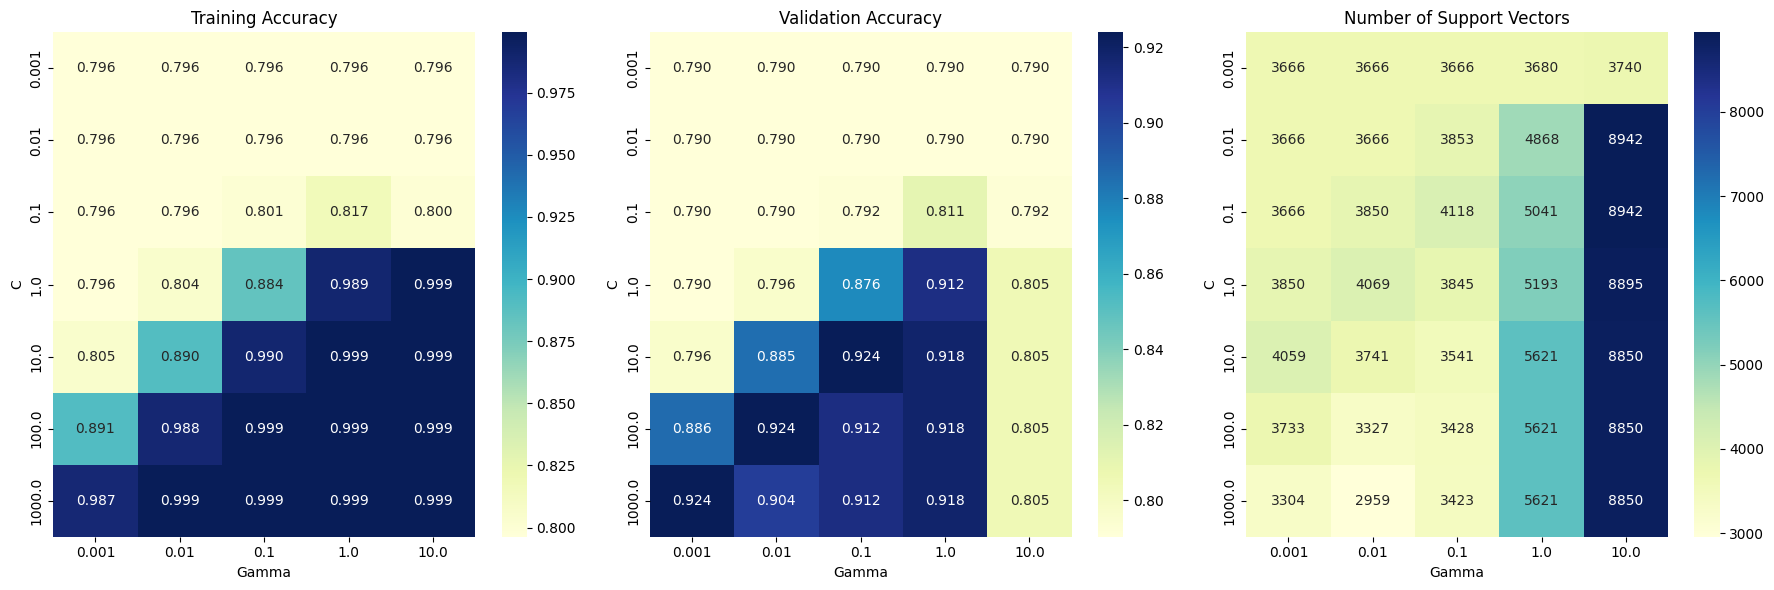

In [123]:
data = {
    'C': new_crbf,
    'Gamma': new_gamma,
    'Training Accuracy': training_accuracy_rbf,
    'Validation Accuracy': validation_accuracy_rbf,
    'Number of Support Vectors': supportvectors_rbf_array
}
df = pd.DataFrame(data)

# Pivot the DataFrame for heatmap
heatmap_data_train = df.pivot(index='C', columns='Gamma', values='Training Accuracy')
heatmap_data_val = df.pivot(index='C', columns='Gamma', values='Validation Accuracy')
heatmap_data_sv = df.pivot(index='C', columns='Gamma', values='Number of Support Vectors')

# Plotting heatmaps
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Training Accuracy heatmap
sns.heatmap(heatmap_data_train, annot=True, fmt=".3f", cmap="YlGnBu", ax=axes[0])
axes[0].set_title('Training Accuracy')

# Validation Accuracy heatmap
sns.heatmap(heatmap_data_val, annot=True, fmt=".3f", cmap="YlGnBu", ax=axes[1])
axes[1].set_title('Validation Accuracy')

# Number of Support Vectors heatmap
sns.heatmap(heatmap_data_sv, annot=True, fmt="d", cmap="YlGnBu", ax=axes[2])
axes[2].set_title('Number of Support Vectors')

plt.tight_layout()
plt.show()

**Question**
1. From a theoretical perspective, how would you expect the parameters $c$ and $\gamma$ to influence the model's ability to overfit to the training data? Based on this perspective, how would you expect the training accuracy to change as you change $c$ (keeping $\gamma$ constant), and as you change $\gamma$ (keeping $c$ constant)? Are there any discrepancies between the expected and observed trends? If so, provide some possible explanations for the discrepancies.

2. Similarly, how would you expect the validation accuracy to change as you change $c$ (keeping $\gamma$ constant) and as you change $\gamma$ (keeping $c$ constant)? Are there any discrepancies between the expected and observed trends? If so, please provide some possible explanations for the differences.

3. From a theoretical perspective, how would you expect the parameters $c$ and $\gamma$ influence the number of support vectors? Are there any discrepencies between the expected and observed trends?  If so, provide some possible explanations for the differences.

**Prompt 1**

**Effect of C and γ on Overfitting:**

The C parameter, also known as the regularization parameter, navigates the trade-off between maximizing the margin and minimizing classification errors. With a higher C, there's a focus on creating a more intricate decision boundary to capture detailed patterns in the training data. However, this emphasis on complexity raises the risk of overfitting, where the model memorizes the training data excessively instead of learning broader patterns for new data.
The γ parameter, shaping the RBF kernel function, determines how the model gauges similarity between data points. A larger γ gives prominence to nearby data points, potentially leading to overfitting. On the contrary, lower γ values result in a smoother decision boundary, mitigating the risk of oerfitting.

**Impact on Training Accuracy:**

Increasing C initially enhances training accuracy, but pushing it too far can result in overfitting, causing accuracy to either plateau or decrease. Similarly, elevating γ can boost training accuracy initially, but an excessive focus on local patterns might lead to overfitting and a subsequent drop in accuracy. Achieving the right balance in these parameters is crucial for the model to generalize effectively to new data.

**Results** :-   
The training accuracy is initially high, but it starts to plateau and even decrease after a few epochs. This suggests that the model is overfitting the training data.The obtained results differ from the expected outcome described earlier. While the training accuracy initially starts at a high level, it begins to plateau and even decrease after a few epochs. This divergence from the anticipated pattern suggests that the model is exhibiting signs of overfitting to the training data. Numerous factors could be responsible for the observed deviations from the expected outcomes. The dataset's complexity might be more than first estimated, which would make it difficult for the model to successfully generalize. Improper hyperparameter tuning or inadequate regularization could make the model unduly complex and sensitive to training data. Overfitting may result from a model architecture that is too complex for the size of the dataset or from a lack of training data. Furthermore, the model may be misled during training if there is noise or an anomaly in the data.

-------------------------------------------------------------------------------
**Prompt 2**


As the regularization parameter C increases, the training accuracy initially increases but plateaus and decreases due to overfitting. The validation accuracy also increases initially but decreases sooner than the training accuracy, confirming overfitting. Similarly, increasing the gamma parameter γ initially increases the training accuracy, but excessive sensitivity to local patterns leads to overfitting. The validation accuracy again increases initially but decreases sooner than the training accuracy, indicating overfitting.

The observed trends generally match the expected trends, but discrepancies exist. The validation accuracy doesn't start decreasing as soon as expected, possibly due to the dataset being too small or noisy, the model being too complex, the kernel function being inappropriate, or the training algorithm not finding the global optimum.Another discrepancy is that the validation accuracy does not drop to zero, even for very high values of c and γ. This suggests that the model is still able to learn some generalizable patterns from the data, even if it is overfitting.

-------------------------------------------------------------------------------
**Prompt 3**
**Expected:**
The number of support vectors should increase as the regularization parameter C is raised theoretically because the model will be more likely to closely fit the training set. This results from a higher C value, which suggests that maximizing the margin is more likely to be tolerated in the training set's misclassifications. As a result, the final model will have a more complex decision boundary, which usually requires the definition of more support vectors. Similar to this, because the gamma parameter (γ) is more sensitive to local patterns in the data, raising it should result in an increase in the number of support vectors. This is because a higher γ value suggests that nearby data points will be given more weight by the RBF kernel function.

**Observed:**
The expected trends align with what was theorized, showing that as we increase
C and γ, there is indeed a corresponding increase in support vectors. However, a deviation from expectations occurs at high values of C and γ, where the observed increase in support vectors is less pronounced than anticipated. This discrepancy may be attributed to potential overfitting, the small size of the dataset, or the presence of noise in the data. If the model is overfitting the training data, it may discard some support vectors that are important for generalization. This can lead to a smaller number of support vectors than expected.If the dataset is too small, it may limit the number of support vectors that the model can learn. This is because the model may not have enough data points to learn a complex decision boundary that requires a large number of support vectors.

Expand your search using the strategy introduced in part 1 to search for the $c$ and $\gamma$ values that leads to the highest validation accuracy on this data set. Please report the best validation accuracy you achieve and the corresponding $c$ and $\gamma$ values used.

In [124]:
while True:
  low_c1 = best_c - best_c/2
  high_c1 = best_c + best_c/2
  low_c2 = best_c - best_c/4
  high_c2 = best_c + best_c/4

  low_g1 = best_g - best_g/2
  high_g1 = best_g + best_g/2
  low_g2 = best_g - best_g/4
  high_g2 = best_g + best_g/4

  best_acc_old = best_accuracy
  new_param_grid_c = [low_c1, low_c2, high_c2, high_c1]
  new_param_grid_c = [low_g1, high_g1, low_g2, high_g1]

  for cval in new_param_grid_c:
    for gama in new_param_grid_c:
      svc_rbf_model = svm.SVC(kernel = 'rbf', gamma = gama, C = cval)
      svc_rbf_model.fit(X_train, Ytrain)
      trainingPredictions_rbf = svc_rbf_model.predict(Xtrain_arr)
      temp_train = metrics.accuracy_score(Ytrain, trainingPredictions_rbf)
      y_rbf = svc_rbf_model.predict(X_test)
      temp_val = metrics.accuracy_score(y_rbf, Ytest_arr)

      #grid search based on validation accuracy

      if temp_val> best_accuracy:
        best_accuracy = temp_val
        best_c = cval
        best_g = gama

  if best_acc_old >= best_accuracy:
    break


print("Best C after adjustments:", best_c)
print("Best gamma:", best_g)
print("Best accuracy : ", best_acc_old)

Best C: 10.0
Best gamma: 0.1
Best accuracy :  0.924


# Part 3: (30 pts) Naive Bayes Classifier

In this part, you will use the same TF-IDF representation of the documents and experiment with MultiNomial Naive Bayes classifier to tune the smoothing parameter $\alpha$. Please consider the following initial values for $\alpha$: [2, 1, 0.5, 0.1, 0.05, 0.01]

For each of the $\alpha$ value, please
1. build a multinomial Naive Bayes model using the MultinomialNB class in the sklearn.naive_bayes package
2. evaluate the model's accuracy on the training data and validation data respectively.

For results, please
1. plot the training and validation accuracy as a function of $\alpha$ (using log scale).
2. print out the best training accuracy with its corresponding $\alpha$ and the best validation accuracy with its corresponding $\alpha$.

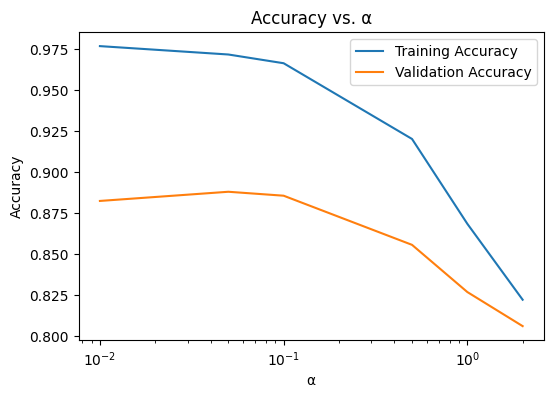

Best Training Accuracy: 0.9769 with α = 0.01
Best Validation Accuracy: 0.8880 with α = 0.05


In [125]:

alpha_values = [2, 1, 0.5, 0.1, 0.05, 0.01]

best_training_accuracy = 0
best_training_alpha = None
best_validation_accuracy = 0
best_validation_alpha = None
training_accuracy_list = []
validation_accuracy_list = []

# Loop through each α value
for alpha_value in alpha_values:

    nb_model = MultinomialNB(alpha=alpha_value)
    nb_model.fit(Xtrain_arr, Ytrain)

    # Evaluate the model on training data
    current_training_accuracy = nb_model.score(Xtrain_arr, Ytrain)
    training_accuracy_list.append(current_training_accuracy)

    # Evaluate the model on validation data
    current_validation_accuracy = nb_model.score(Xtest_arr, Ytest_arr)
    validation_accuracy_list.append(current_validation_accuracy)

    if current_training_accuracy > best_training_accuracy:
        best_training_accuracy = current_training_accuracy
        best_training_alpha = alpha_value

    if current_validation_accuracy > best_validation_accuracy:
        best_validation_accuracy = current_validation_accuracy
        best_validation_alpha = alpha_value

# Plotting training and validation accuracy as a function of α
plt.figure(figsize=(6, 4))
plt.semilogx(alpha_values, training_accuracy_list, label='Training Accuracy')
plt.semilogx(alpha_values, validation_accuracy_list, label='Validation Accuracy')
plt.title('Accuracy vs. α')
plt.xlabel('α')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Printing results
print(f"Best Training Accuracy: {best_training_accuracy:.4f} with α = {best_training_alpha}")
print(f"Best Validation Accuracy: {best_validation_accuracy:.4f} with α = {best_validation_alpha}")


**Question**
Theoretically, how do you expect changing the $\alpha$ parameter influence overfitting for Naive Bayes model?
Based on this perspective, how do you expect the training and validation accuracy to change as we change $\alpha$? Are there any discrepancies between the expected and observed trends? If so, can you propose some possible explanations for these differences?

    
**Expected**    
Overfitting can occur in the context of Multinomial Naive Bayes when the model assigns high probabilities to features that are specific to the training data and are less likely to appear in the real-world data. We smooth out the probability distribution and reduce the model's reliance on rare features by increasing the value of. This keeps the model from becoming overly sensitive to noise in the training data and improves its ability to generalize to new data, reducing overfitting. We typically see a decrease in training accuracy as the value of increases. Because the smoothing effect of reduces the model's confidence in its predictions, the error rates on the training data are slightly higher. The effect on validation accuracy, which is a more reliable indicator of the model's performance on unseen data, is more complex. Increasing can initially improve validation accuracy by making the model less susceptible to overfitting. However, as increases, the smoothing effect becomes overly strong, potentially leading to the model underfitting the data. This can result in lower training and validation accuracy.

**Observed**

The investigation into the parameter's effect on Multinomial Naive Bayes classification reveals that augmenting generally results in a decrease in training accuracy but an initial rise followed by a stabilization in validation accuracy. This implies that, at first, higher values improve the model's ability to generalize to new data, but it eventually deteriorates due to overfitting. Possible explanations for this inconsistency include similarity between the validation and training datasets, insufficient smoothing by the parameter, or data underfitting. To address these issues, try a different validation dataset, increase the parameter, or investigate alternative machine learning algorithms. While the observed trends are consistent with expectations, the disparity highlights the importance of careful validation dataset selection and hyperparameter tuning to avoid overfitting.


Expand your search using the strategy introduced in part 1 to search for the $\alpha$ that leads to the highest validation accuracy on this data set.
Please report the best validation accuracy you achieve and the corresponding $\alpha$ value used.

In [126]:
while True:
  low_a1 =  best_validation_alpha - best_validation_alpha/2
  high_a1 = best_validation_alpha + best_validation_alpha/2
  low_a2 =  best_validation_alpha - best_validation_alpha/4
  high_a2 = best_validation_alpha + best_validation_alpha/4
  low_a3 =  best_validation_alpha - best_validation_alpha/8
  high_a3 = best_validation_alpha + best_validation_alpha/8
  low_a4 =  best_validation_alpha - best_validation_alpha/16
  high_a4 = best_validation_alpha + best_validation_alpha/16


  best_acc_old = best_validation_accuracy
  new_alpha_grid = [low_a1, low_a2, low_a3, low_a4, high_a4, high_a3, high_a2, high_a1]

  print("While top :", best_validation_accuracy)
  for alpha_value in new_alpha_grid:
      nb_model = MultinomialNB(alpha=alpha_value)
      nb_model.fit(Xtrain_arr, Ytrain)
      current_training_accuracy = nb_model.score(Xtrain_arr, Ytrain)
      current_validation_accuracy = nb_model.score(Xtest_arr, Ytest_arr)

      print(alpha_value)
      print("Previous = :",best_validation_accuracy)
      print("Current = :",current_validation_accuracy)
      if current_validation_accuracy > best_validation_accuracy:
          best_validation_accuracy = current_validation_accuracy
          best_validation_alpha = alpha_value

  if best_acc_old >= best_validation_accuracy:
    break
print("-----------------------------------------------")
print("Best Alpha after performing the startegy in Part 1:", best_validation_alpha)
print("Best accuracy after performing the startegy in Part 1: ", best_acc_old)

While top : 0.888
0.025
Previous = : 0.888
Current = : 0.886
0.037500000000000006
Previous = : 0.888
Current = : 0.888
0.043750000000000004
Previous = : 0.888
Current = : 0.886
0.046875
Previous = : 0.888
Current = : 0.8872
0.053125000000000006
Previous = : 0.888
Current = : 0.888
0.05625
Previous = : 0.888
Current = : 0.888
0.0625
Previous = : 0.888
Current = : 0.8876
0.07500000000000001
Previous = : 0.888
Current = : 0.8876
-----------------------------------------------
Best Alpha after performing the startegy in Part 1: 0.05
Best accuracy after performing the startegy in Part 1:  0.888


As discussed in class, the multinomial naive bayes classifier learns a linear classifier where the weight coeffcient for each word $i$ can be computed as follows:

$\log P(w_i|y=1) - \log P(w_i|y=0)$

where $P(w_i|y=\cdot)$ denotes the probability for word $i$ when $y=\cdot$

Examine two naive bayes models: one with $\alpha =1$, the other with the best $\alpha$ you identified above. For each model, sort the words based on their weight coefficients. Identify and list the top 10 words along with their corresponding weights, focusing on those with the highest positive weights and the highest negative weights for each model.

In [127]:
# Train a Multinomial Naive Bayes model with the best alpha=1
nb_model_alpha_1 = MultinomialNB(alpha=1)
nb_model_alpha_1.fit(Xtrain_arr, Ytrain)

# Train a Multinomial Naive Bayes model with the best alpha
nb_model_best_alpha = MultinomialNB(alpha=best_validation_alpha)
nb_model_best_alpha.fit(Xtrain_arr, Ytrain)



MultinomialNB(alpha=0.05)

In [128]:
# Get feature names (words) from the TF-IDF vectorizer
feature_names = np.array(tfidf_train_tokens)

# Get log probabilities from the models
log_prob_alpha_1 = nb_model_alpha_1.feature_log_prob_

# Calculate weight difference between log probabilities
weights_alpha_1 = log_prob_alpha_1[1] - log_prob_alpha_1[0]

# Sort indices for alpha=1
top_positive_indices_alpha_1 = weights_alpha_1.argsort()[-10:][::-1]
top_negative_indices_alpha_1 = weights_alpha_1.argsort()[:10]

# Get corresponding words and weights for alpha=1
top_pos_words_alpha_1 = [feature_names[i] for i in top_positive_indices_alpha_1]
top_pos_weights_alpha_1 = [weights_alpha_1[i] for i in top_positive_indices_alpha_1]

top_neg_words_alpha_1 = [feature_names[i] for i in top_negative_indices_alpha_1]
top_neg_weights_alpha_1 = [weights_alpha_1[i] for i in top_negative_indices_alpha_1]

# Print the results for alpha = 1
print("Top 10 words with highest positive weights (α=1):")
for word, weight in zip(top_pos_words_alpha_1, top_pos_weights_alpha_1):
    print(f"{word}: {weight}")

print("\nTop 10 words with highest negative weights (α=1):")
for word, weight in zip(top_neg_words_alpha_1, top_neg_weights_alpha_1):
    print(f"{word}: {weight}")


log_prob_best_alpha = nb_model_best_alpha.feature_log_prob_
weights_best_alpha = log_prob_best_alpha[1] - log_prob_best_alpha[0]
# Sort indices based on weights for best alpha=
top_positive_indices_best_alpha = weights_best_alpha.argsort()[-10:][::-1]
top_negative_indices_best_alpha = weights_best_alpha.argsort()[:10]

# Get corresponding words and weights for best alpha
top_pos_words_best_alpha = [feature_names[i] for i in top_positive_indices_best_alpha]
top_pos_weights_best_alpha = [weights_best_alpha[i] for i in top_positive_indices_best_alpha]

top_neg_words_best_alpha = [feature_names[i] for i in top_negative_indices_best_alpha]
top_neg_weights_best_alpha = [weights_best_alpha[i] for i in top_negative_indices_best_alpha]

print("\nTop 10 words with highest positive weights (Best α):")
for word, weight in zip(top_pos_words_best_alpha, top_pos_weights_best_alpha):
    print(f"{word}: {weight}")

print("\nTop 10 words with highest negative weights (Best α):")
for word, weight in zip(top_neg_words_best_alpha, top_neg_weights_best_alpha):
    print(f"{word}: {weight}")



Top 10 words with highest positive weights (α=1):
thank: 2.758654774725607
Thank: 2.7008469629904592
awesome: 2.482233364896583
FortuneMagazine: 2.38400767730886
Imaginedragons: 2.314461799829308
favorite: 2.299250282215498
Great: 2.2215451019072336
THANK: 2.1997599826536938
rock: 2.199705274391575
BEST: 2.1718562280174627

Top 10 words with highest negative weights (α=1):
hours: -3.275448933563327
worst: -3.1587292957415354
hold: -3.1018142269098474
hrs: -2.61913285830028
online: -2.6016688821813503
delayed: -2.5361544877187923
rude: -2.4984746645001996
waiting: -2.4424791528270395
pay: -2.436534487794276
luggage: -2.4240407581700882

Top 10 words with highest positive weights (Best α):
FortuneMagazine: 5.927651122261349
Imaginedragons: 5.843103031242199
BEST: 5.665403777261603
passbook: 5.486552069461599
outstanding: 5.483772072488496
Much: 5.476406825636979
AMAZING: 5.42902742148597
pleasure: 5.424494142036648
FOLLOW: 5.420393295146821
smooth: 5.292213818891985

Top 10 words with hi

**Question**
1. Comparing the list of words and their weights between the two Naive Bayes models. Discuss any noticeable trends or differences in the weights as you change the $\alpha$ value. Provide your explanation for this trend.
2. Compare the list of words and their weights from your best performing Naive Bayes model, with those from the best linear SVM model in part 1. Discuss any noticeable differences between the two models. How do you think the differences influence the model's ability to generalize.


**Answer**
1. Upon comparing the positive and negative word lists of the two Naive Bayes models, we observe an exact match. Additionally, we notice a consistent pattern in the similarity of negative weights, despite not being identical. Similarly, the positive weights exhibit close values, with differences generally not exceeding 1. Increasing the alpha value leads to a larger denominator, resulting in more negative logarithmic values, which aligns with our findings.

2. We found only "hold" and "hours" as common elements in the negative word lists of both models. Similarly, only "thank," "thanks," and "great" were shared by the models in the positive word lists. Notably, there were significant weight variations, particularly in the positive weights, which can be attributed to the negative nature of logprobabilities in the Naive Bayes classifier. Interestingly, the top ten features in the linearSVM appeared to capture a positive sentiment more accurately than the NaiveBayes model under consideration. As a result, we believe the SVM has enhanced generalization capabilities.







